In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

c:\Users\vibal\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_mcc'
metric_filter_2 = 'test_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.6, 0.15, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = dataset.num_classes

In [6]:
(dataset[0].ndata['train_mask']).sum()

tensor(900)

In [7]:
(dataset[0].ndata['val_mask']).sum()

tensor(225)

In [8]:
(dataset[0].ndata['test_mask']).sum()

tensor(375)

## Baseline

In [9]:
dict_small_acc_train = {}
dict_small_acc_val = {}
dict_small_acc_test = {}
dict_small_rmse_train = {}
dict_small_rmse_val = {}
dict_small_rmse_test = {}
dict_small_mcc_train = {}
dict_small_mcc_val = {}
dict_small_mcc_test = {}

In [10]:
# x_train,x_test,y_train,y_test = train_test_split(dataset.node_features[0].to_numpy(), dataset.targets[0], test_size=0.25, random_state=seed)
g_data = dataset.graphs[0].ndata
feats = g_data['feat']
labels = g_data['label']
train_mask = g_data['train_mask']
val_mask = g_data['val_mask']
test_mask = g_data['test_mask']

# train + val for training, test for test
x_train,x_test = feats[torch.logical_not(test_mask)], feats[test_mask]
y_train,y_test = labels[torch.logical_not(test_mask)], labels[test_mask]

In [11]:
x_train.shape

torch.Size([1125, 4])

In [12]:
x_test.shape

torch.Size([375, 4])

### Logistic Regression

In [13]:
model_lr = LogisticRegression(multi_class='multinomial',random_state=seed, max_iter=800).fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=model_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67        98
           1       0.21      0.05      0.08        95
           2       0.34      0.53      0.41        93
           3       0.55      0.79      0.65        89

    accuracy                           0.49       375
   macro avg       0.46      0.49      0.45       375
weighted avg       0.46      0.49      0.45       375



In [14]:
dict_small_acc_train['logistic_regression'] = model_lr.score(x_train, y_train)
dict_small_acc_test['logistic_regression'] = model_lr.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['logistic_regression']}")
print(f"Test accuracy: {dict_small_acc_test['logistic_regression']}")

dict_small_rmse_train['logistic_regression'] = mean_squared_error(y_true=y_train,y_pred=model_lr.predict(x_train), squared=False)
dict_small_rmse_test['logistic_regression'] = mean_squared_error(y_true=y_test,y_pred=model_lr.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['logistic_regression']}")
print(f"Test rmse: {dict_small_rmse_test['logistic_regression']}")

dict_small_mcc_train['logistic_regression'] = matthews_corrcoef(y_true=y_train,y_pred=model_lr.predict(x_train))
dict_small_mcc_test['logistic_regression'] = matthews_corrcoef(y_true=y_test,y_pred=model_lr.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['logistic_regression']}")
print(f"Test mcc: {dict_small_mcc_test['logistic_regression']}")

Train accuracy: 0.4951111111111111
Test accuracy: 0.488
Train rmse: 0.9693067396627115
Test rmse: 0.9605553948974868
Train mcc: 0.3431624245917755
Test mcc: 0.33524435059932634


### Random Forest

In [15]:
# # x_train_rf,x_val_rf,y_train_rf,y_val_rf = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)
# x_train_rf,x_val_rf,x_test_rf = feats[train_mask], feats[val_mask], feats[test_mask]
# y_train_rf,y_val_rf,y_test_rf = labels[train_mask], labels[val_mask], labels[test_mask]
x_train_rf = x_train
y_train_rf = y_train
x_val_rf = x_test
y_val_rf = y_test

In [16]:
n = 20
num_nodes = x_train_rf.shape[0]
model_rf = None
val_acc = 0.0
for k in trange(1,num_nodes, (num_nodes - 1) // n):
    tmp = RandomForestClassifier(random_state=seed, n_estimators=k).fit(x_train_rf,y_train_rf)
    tmp_acc = matthews_corrcoef(y_true=y_val_rf,y_pred=tmp.predict(x_val_rf))
    if val_acc < tmp_acc:
        val_acc = tmp_acc
        model_rf = tmp

print(classification_report(y_true=y_test, y_pred=model_rf.predict(x_test)))

100%|██████████| 21/21 [00:58<00:00,  2.77s/it]

              precision    recall  f1-score   support

           0       0.68      0.70      0.69        98
           1       0.38      0.35      0.36        95
           2       0.31      0.30      0.31        93
           3       0.58      0.63      0.60        89

    accuracy                           0.50       375
   macro avg       0.49      0.50      0.49       375
weighted avg       0.49      0.50      0.49       375



In [17]:
model_rf

RandomForestClassifier(n_estimators=57, random_state=4444)

In [18]:
dict_small_acc_train['random_forest'] = model_rf.score(x_train_rf, y_train_rf)
dict_small_acc_val['random_forest'] = model_rf.score(x_val_rf, y_val_rf)
dict_small_acc_test['random_forest'] = model_rf.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['random_forest']}")
print(f"Val accuracy: {dict_small_acc_val['random_forest']}")
print(f"Test accuracy: {dict_small_acc_test['random_forest']}")

dict_small_rmse_train['random_forest'] = mean_squared_error(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf), squared=False)
dict_small_rmse_val['random_forest'] = mean_squared_error(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf), squared=False)
dict_small_rmse_test['random_forest'] = mean_squared_error(y_true=y_test,y_pred=model_rf.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['random_forest']}")
print(f"Val rmse: {dict_small_rmse_val['random_forest']}")
print(f"Test rmse: {dict_small_rmse_test['random_forest']}")

dict_small_mcc_train['random_forest'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf))
dict_small_mcc_val['random_forest'] = matthews_corrcoef(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf))
dict_small_mcc_test['random_forest'] = matthews_corrcoef(y_true=y_test,y_pred=model_rf.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['random_forest']}")
print(f"Val mcc: {dict_small_mcc_val['random_forest']}")
print(f"Test mcc: {dict_small_mcc_test['random_forest']}")

Train accuracy: 1.0
Val accuracy: 0.496
Test accuracy: 0.496
Train rmse: 0.0
Val rmse: 0.977070451229934
Test rmse: 0.977070451229934
Train mcc: 1.0
Val mcc: 0.3281549927912905
Test mcc: 0.3281549927912905


### KNN Classifier

In [19]:
model_knn = KNeighborsClassifier(n_neighbors=out_feats).fit(x_train,y_train)
print(classification_report(y_true=y_test, y_pred=model_knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65        98
           1       0.25      0.27      0.26        95
           2       0.26      0.27      0.26        93
           3       0.45      0.34      0.38        89

    accuracy                           0.39       375
   macro avg       0.39      0.39      0.39       375
weighted avg       0.40      0.39      0.39       375



In [20]:
dict_small_acc_train['knn_classifier'] = model_knn.score(x_train_rf, y_train_rf)
dict_small_acc_test['knn_classifier'] = model_knn.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['knn_classifier']}")
print(f"Test accuracy: {dict_small_acc_test['knn_classifier']}")

dict_small_rmse_train['knn_classifier'] = mean_squared_error(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf), squared=False)
dict_small_rmse_test['knn_classifier'] = mean_squared_error(y_true=y_test,y_pred=model_knn.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['knn_classifier']}")
print(f"Test rmse: {dict_small_rmse_test['knn_classifier']}")

dict_small_mcc_train['knn_classifier'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf))
dict_small_mcc_test['knn_classifier'] = matthews_corrcoef(y_true=y_test,y_pred=model_knn.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['knn_classifier']}")
print(f"Test mcc: {dict_small_mcc_test['knn_classifier']}")

Train accuracy: 0.6328888888888888
Test accuracy: 0.392
Train rmse: 0.977070451229934
Test rmse: 1.1372481406154653
Train mcc: 0.5121440277091303
Test mcc: 0.18845797689767943


### FNN

In [21]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [22]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=False,
        )

100%|██████████| 60/60 [05:00<00:00,  5.01s/it]


#### Results

In [23]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 990/990 [00:40<00:00, 24.54it/s]


In [24]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.3568035542923658,
 'epoch': 90,
 'train_loss': 1.0261517,
 'train_acc': 0.5088889002799988,
 'val_acc': 0.5022221803665161,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.50_2023-03-29_00.25.02.569359_90',
 'train_rmse': 0.901233722306385,
 'val_rmse': 0.9116529554118229,
 'test_rmse': 0.9033271832508971,
 'train_mae': 0.5966666666666667,
 'val_mae': 0.6088888888888889,
 'test_mae': 0.5866666666666667,
 'train_mcc': 0.36310642501801277,
 'test_mcc': 0.388852407328723,
 'test_acc': 0.5253333449363708,
 'train_rmse_perc': 0.21904565,
 'val_rmse_perc': 0.224565,
 'test_rmse_perc': 0.21605416,
 'train_mae

In [25]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.41384460820172747,
 'epoch': 48,
 'train_loss': 1.0777864,
 'train_acc': 0.504444420337677,
 'val_acc': 0.5199999809265137,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.52_2023-03-29_00.27.21.845987',
 'train_rmse': 0.9086008780292674,
 'val_rmse': 0.8640987597877147,
 'test_rmse': 0.9048020041239225,
 'train_mae': 0.6033333333333334,
 'val_mae': 0.5688888888888889,
 'test_mae': 0.6,
 'train_mcc': 0.37243629941029666,
 'test_mcc': 0.38116118015130046,
 'test_acc': 0.5093333125114441,
 'train_rmse_perc': 0.22163007,
 'val_rmse_perc': 0.21157216,
 'test_rmse_perc': 0.21774465,
 'train_mae_perc': 0.17

In [26]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.37034517059315547,
 'epoch': 41,
 'train_loss': 1.2651892,
 'train_acc': 0.49444442987442017,
 'val_acc': 0.47999995946884155,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.48_2023-03-29_00.23.19.514337',
 'train_rmse': 0.8956685895029601,
 'val_rmse': 0.8944271909999159,
 'test_rmse': 0.9194201070964967,
 'train_mae': 0.6022222222222222,
 'val_mae': 0.6133333333333333,
 'test_mae': 0.6,
 'train_mcc': 0.3732398842625206,
 'test_mcc': 0.4090910874795033,
 'test_acc': 0.5199999809265137,
 'train_rmse_perc': 0.21874109,
 'val_rmse_perc': 0.21824172,
 'test_rmse_perc': 0.22048295,
 'train_mae_perc': 0.17174

In [27]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 990/990 [00:00<00:00, 28604.42it/s]


In [28]:
cm = all[sort_idx[0]]['test_cm'][0]

In [29]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

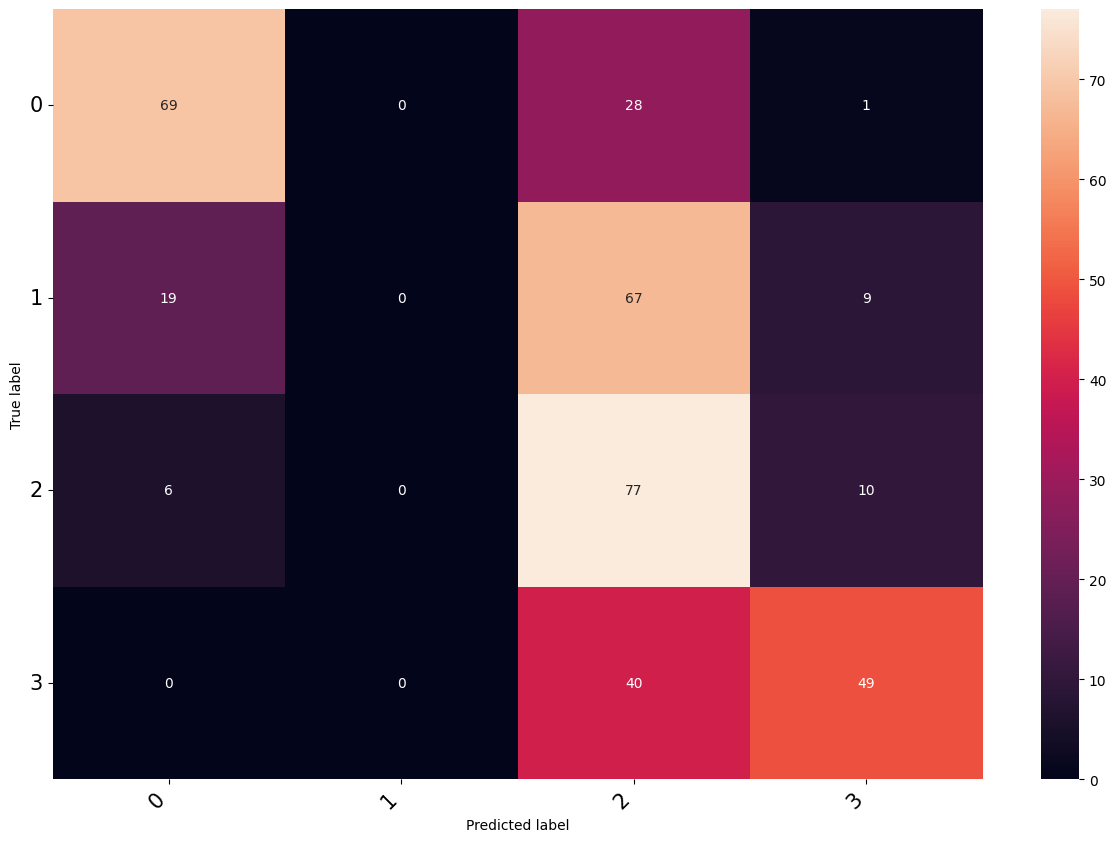

In [30]:
cm.visualize()

In [31]:
cm.class_accuracy

tensor([0.7041, 0.0000, 0.8280, 0.5506])

### Baseline Overall

In [32]:
print(dict_small_acc_train)
print(dict_small_acc_val)
print(dict_small_acc_test)

{'logistic_regression': 0.4951111111111111, 'random_forest': 1.0, 'knn_classifier': 0.6328888888888888}
{'random_forest': 0.496}
{'logistic_regression': 0.488, 'random_forest': 0.496, 'knn_classifier': 0.392}


In [33]:
print(dict_small_mcc_train)
print(dict_small_mcc_val)
print(dict_small_mcc_test)

{'logistic_regression': 0.3431624245917755, 'random_forest': 1.0, 'knn_classifier': 0.5121440277091303}
{'random_forest': 0.3281549927912905}
{'logistic_regression': 0.33524435059932634, 'random_forest': 0.3281549927912905, 'knn_classifier': 0.18845797689767943}


In [34]:
print(dict_small_rmse_train)
print(dict_small_rmse_val)
print(dict_small_rmse_test)

{'logistic_regression': 0.9693067396627115, 'random_forest': 0.0, 'knn_classifier': 0.977070451229934}
{'random_forest': 0.977070451229934}
{'logistic_regression': 0.9605553948974868, 'random_forest': 0.977070451229934, 'knn_classifier': 1.1372481406154653}


### GCN

In [35]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [36]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 144/144 [20:22<00:00,  8.49s/it]


#### Results

In [37]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 2293/2293 [03:32<00:00, 10.81it/s]


In [38]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.50314815358739,
 'epoch': 70,
 'train_loss': 0.72641623,
 'train_acc': 0.6733333468437195,
 'val_acc': 0.6222221851348877,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.62_2023-03-29_00.35.55.303906_70',
 'train_rmse': 0.6641619615057092,
 'val_rmse': 0.7453559924999299,
 'test_rmse': 0.6870225614927067,
 'train_mae': 0.3611111111111111,
 'val_mae': 0.4311111111111111,
 'test_mae': 0.36,
 'train_mcc': 0.5671681774268817,
 'test_mcc': 0.589183540529164,
 'test_acc': 0.6880000233650208,
 'train_rmse_perc': 0.16308792,
 'val_rmse_perc': 0.17602557,
 'test_rmse_perc': 0.16053888,
 '

In [39]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5926337683909628,
 'epoch': 16,
 'train_loss': 0.9201429,
 'train_acc': 0.6299999952316284,
 'val_acc': 0.6933332681655884,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.69_2023-03-29_00.30.52.360322',
 'train_rmse': 0.731057073315377,
 'val_rmse': 0.6666666666666666,
 'test_rmse': 0.8516650358758033,
 'train_mae': 0.4211111111111111,
 'val_mae': 0.3466666666666667,
 'test_mae': 0.5013333333333333,
 'train_mcc': 0.5076921604496102,
 'test_mcc': 0.45779093289970435,
 'test_acc': 0.5920000076293945,
 'train_rmse_perc': 0.18412827,
 'val_rmse_perc': 0.16359332,
 'test_rmse_perc': 0

In [40]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.50314815358739,
 'epoch': 70,
 'train_loss': 0.72641623,
 'train_acc': 0.6733333468437195,
 'val_acc': 0.6222221851348877,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.62_2023-03-29_00.35.55.303906_70',
 'train_rmse': 0.6641619615057092,
 'val_rmse': 0.7453559924999299,
 'test_rmse': 0.6870225614927067,
 'train_mae': 0.3611111111111111,
 'val_mae': 0.4311111111111111,
 'test_mae': 0.36,
 'train_mcc': 0.5671681774268817,
 'test_mcc': 0.589183540529164,
 'test_acc': 0.6880000233650208,
 'train_rmse_perc': 0.16308792,
 'val_rmse_perc': 0.17602557,
 'test_rmse_perc': 0.16053888,
 '

In [41]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2293/2293 [00:00<00:00, 24144.59it/s]


### GraphSAGE

In [42]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    # aggregator_type = ['mean', 'lstm'],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [43]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 288/288 [4:04:03<00:00, 50.85s/it]  


#### Results

In [44]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 6956/6956 [27:40<00:00,  4.19it/s]


In [45]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8299218814058614,
 'epoch': 83,
 'train_loss': 0.67872584,
 'train_acc': 0.9677777886390686,
 'val_acc': 0.8711110353469849,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.87_2023-03-29_03.52.21.151742',
 'train_rmse': 0.17950549357115014,
 'val_rmse': 0.37712361663282534,
 'test_rmse': 0.4501851470969102,
 'train_mae': 0.03222222222222222,
 'val_mae': 0.13333333333333333,
 'test_mae': 0.16533333333333333,
 'train_mcc': 0.9570508014285876,
 'test_mcc': 0.8015005786048982,
 'test_acc': 0.8506666421890259,
 'train_rmse_perc': 0.07665145,
 'val_rmse_p

In [46]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8348284336610686,
 'epoch': 84,
 'train_loss': 0.6777317,
 'train_acc': 0.9688888788223267,
 'val_acc': 0.8755555152893066,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.88_2023-03-29_03.52.21.151742',
 'train_rmse': 0.17638342073763938,
 'val_rmse': 0.38873012632302,
 'test_rmse': 0.45607017003965516,
 'train_mae': 0.03111111111111111,
 'val_mae': 0.13333333333333333,
 'test_mae': 0.17066666666666666,
 'train_mcc': 0.9585557428383105,
 'test_mcc': 0.7943860550275696,
 'test_acc': 0.8453333377838135,
 'train_rmse_perc': 0.076360986,
 'val_rmse_per

In [47]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8299218814058614,
 'epoch': 83,
 'train_loss': 0.67872584,
 'train_acc': 0.9677777886390686,
 'val_acc': 0.8711110353469849,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.87_2023-03-29_03.52.21.151742',
 'train_rmse': 0.17950549357115014,
 'val_rmse': 0.37712361663282534,
 'test_rmse': 0.4501851470969102,
 'train_mae': 0.03222222222222222,
 'val_mae': 0.13333333333333333,
 'test_mae': 0.16533333333333333,
 'train_mcc': 0.9570508014285876,
 'test_mcc': 0.8015005786048982,
 'test_acc': 0.8506666421890259,
 'train_rmse_perc': 0.07665145,
 'val_rmse_p

In [48]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 6956/6956 [00:00<00:00, 18305.35it/s]


#### cm

In [49]:
cm = all[sort_idx[0]]['test_cm'][0]

In [50]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

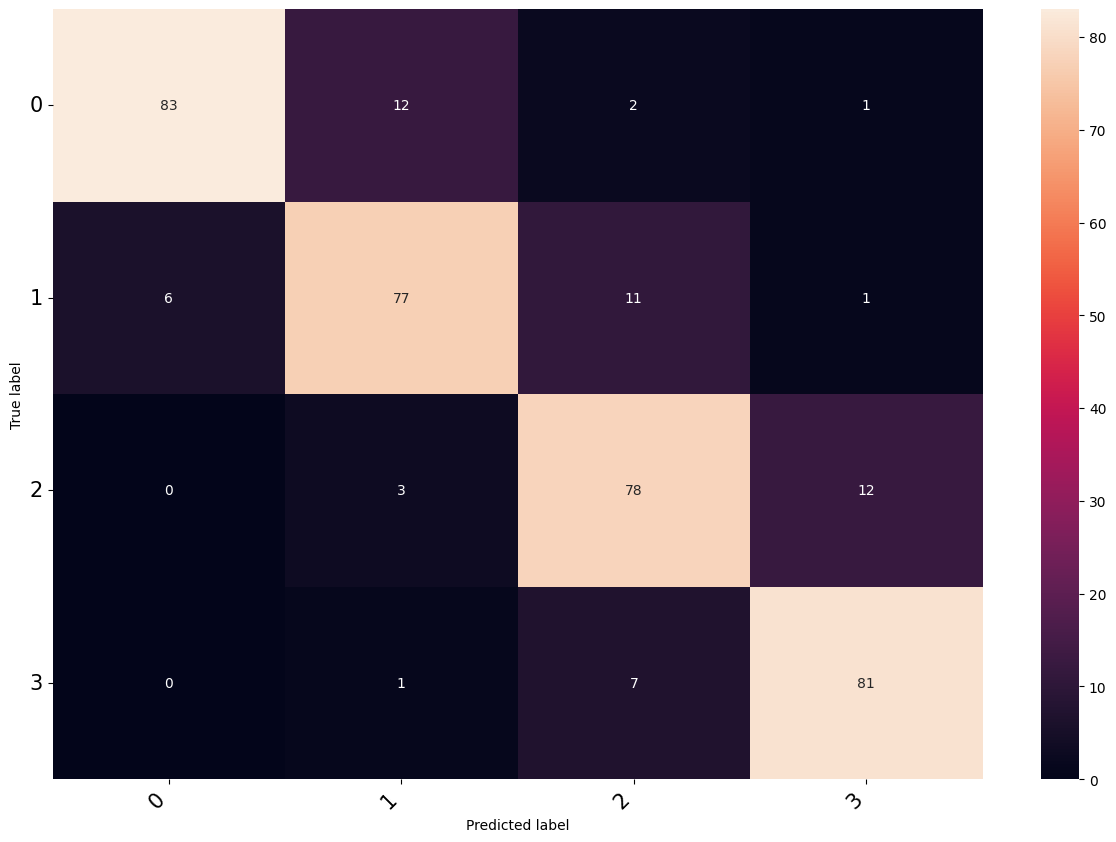

In [51]:
cm.visualize()

In [52]:
cm.class_accuracy

tensor([0.8469, 0.8105, 0.8387, 0.9101])

### GAT

In [53]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [54]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 576/576 [1:44:31<00:00, 10.89s/it]


#### Results

In [55]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 10640/10640 [13:00<00:00, 13.63it/s]


In [56]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.4462712003664335,
 'epoch': 51,
 'train_loss': 1.4128174,
 'train_acc': 0.5611110925674438,
 'val_acc': 0.5777777433395386,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.58_2023-03-29_06.20.06.137611',
 'train_rmse': 0.9104333522498442,
 'val_rmse': 0.940449065311059,
 'test_rmse': 0.9811557810392123,
 'train_mae': 0.5555555555555556,
 'val_mae': 0.5555555555555556,
 'test_mae': 0.6213333333333333,
 'train_mcc': 0.4189372848325069,
 'test_mcc': 0.37492488321074074,
 'test_acc': 0.527999997138977,
 'train_rmse_perc': 0.227

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10],
 'out_features': 4,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.48795024184845764,
 'epoch': 95,
 'train_loss': 1.3085786,
 'train_acc': 0.5888888835906982,
 'val_acc': 0.6177777647972107,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.62_2023-03-29_05.29.48.406075',
 'train_rmse': 0.856997342145496,
 'val_rmse': 0.8894442709417556,
 'test_rmse': 0.9619424792228137,
 'train_mae': 0.51,
 'val_mae': 0.5066666666666667,
 'test_mae': 0.6213333333333333,
 'train_mcc': 0.45563987765258845,
 'test_mcc': 0.36120959259034774,
 'test_acc': 0.5199999809265137,
 'train_rmse_perc': 0.21392599,
 'va

In [58]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.4462712003664335,
 'epoch': 51,
 'train_loss': 1.4128174,
 'train_acc': 0.5611110925674438,
 'val_acc': 0.5777777433395386,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.58_2023-03-29_06.20.06.137611',
 'train_rmse': 0.9104333522498442,
 'val_rmse': 0.940449065311059,
 'test_rmse': 0.9811557810392123,
 'train_mae': 0.5555555555555556,
 'val_mae': 0.5555555555555556,
 'test_mae': 0.6213333333333333,
 'train_mcc': 0.4189372848325069,
 'test_mcc': 0.37492488321074074,
 'test_acc': 0.527999997138977,
 'train_rmse_perc': 0.227

In [59]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 10640/10640 [00:00<00:00, 18170.98it/s]


In [60]:
cm = all[sort_idx[0]]['test_cm'][0]

In [61]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

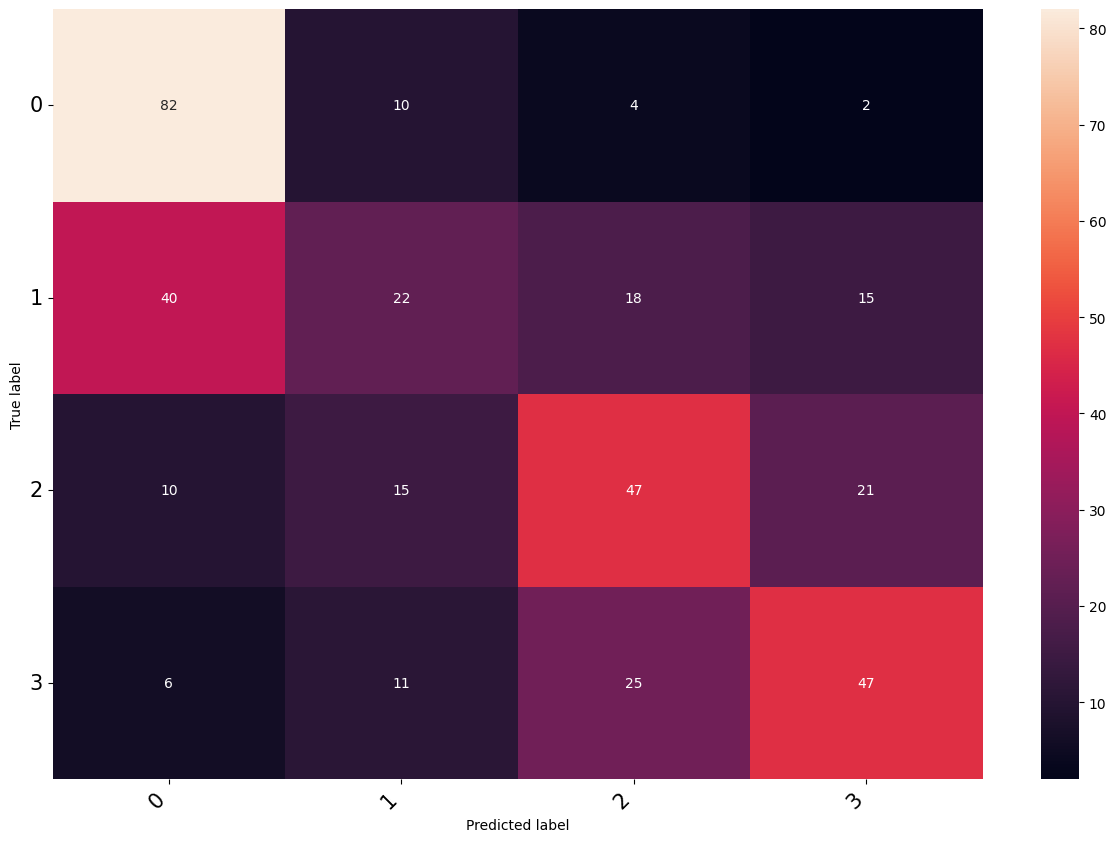

In [62]:
cm.visualize()

In [63]:
cm.class_accuracy

tensor([0.8367, 0.2316, 0.5054, 0.5281])